In [12]:
from tqdm.auto import tqdm

## Load documents with IDs

In [1]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

/Users/dandyrahman/Documents/Projects/LLM-ZoomCamp/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth

In [3]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [6]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [8]:
doc_idx.keys()

dict_keys(['c02e79ef', '1f6520ca', '7842b56a', '0bbf41ec', '63394d91', '2ed9b986', '93e2c8ed', 'a482086d', 'eb56ae98', '4292531b', 'ea739c65', 'cb257ee5', '04aa4897', '9681be3b', 'a1daf537', 'be5bfee4', '0e424a44', '29865466', '016d46a1', '47972cb1', 'ddf6c1b3', 'ac25d3af', '251218fc', '3c0114ce', 'f43f5fe7', 'd061525d', '1cd01b2c', 'e4a7c3b0', '7cd1912e', '52393fb3', '10515af5', 'cdb86a97', '3e0114ad', 'b2799574', '2f19301f', '7c700adb', '44b14808', '76e4baf6', '48b533a8', '954044d1', 'a820b9b3', 'f2945cd2', 'eb9d376f', '72f25f6d', 'a1e59afc', '71c10610', '17a5aea1', '5a275db7', '7ec0f9b0', 'bb1ba786', '2f83dbe7', '543ff080', 'd407d65b', 'c9375c56', 'e866156b', '16370470', '316df755', 'f3aa9252', 'a4abe7a5', 'fb930700', 'aa187680', 'b000e899', '9c66759f', 'e3106e07', '72229da5', '58c9f99f', 'bc42139a', 'a146e3ee', '593a85ba', '50bd1a71', 'f409f751', '7d217da3', '09081824', '4df80c55', '3aee7261', '6497b659', 'a02f2039', 'c6db65aa', 'f476a606', 'e41b100c', 'cd0f9300', '7f845a1c', '36e5

## Index data

In [9]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/Users/dandyrahman/Documents/Projects/LLM-ZoomCamp/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200')

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

# Check if the index already exists
if not es_client.indices.exists(index=index_name):
    es_client.indices.create(index=index_name, body=index_settings)
    print(f"Index '{index_name}' created successfully.")

    
    # Filling index
    for doc in tqdm(documents):
        question = doc['question']
        text = doc['text']
        doc['question_text_vector'] = model.encode(question + ' ' + text)

        es_client.index(index=index_name, document=doc)

else:
    print(f"Index '{index_name}' already exists.")

Index 'course-questions' already exists.


## Retrieval


In [13]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [14]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow


In [15]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [16]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [27]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)

    return answer

In [18]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [28]:
rag(ground_truth[10])

'Yes, sessions are recorded if you miss one. You can access the recordings and catch up on any missed content. Additionally, you can ask your questions in advance for office hours, which are also recorded, and engage through Slack.'

In [29]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric


In [32]:
answer_llm = 'Yes, sessions are recorded if you miss one. You can access the recordings and catch up on any missed content. Additionally, you can ask your questions in advance for office hours, which are also recorded, and engage through Slack.'
answer_orig = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.6965563

## Calculating Cosine Similarity for Every Question

### GPT4o

In [44]:
answers = {}

In [46]:
count = 0

for i, rec in enumerate(tqdm(ground_truth)):
    if count == 10:
        break

    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],

    }

    count += 1

  1%|          | 10/1830 [00:37<1:53:39,  3.75s/it]


In [47]:
answers

{0: {'answer_llm': 'You can sign up for the course by going to the course page at http://mlzoomcamp.com/. From there, scroll down to access and start going through the course materials. If you are looking for the syllabus directly, you can use this link: http://mlzoomcamp.com/#syllabus.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 1: {'answer_llm': 'You can find the link to sign up in the course GitHub repository. Here it is: [https://airtable.com/shryxwLd0COOEaqXo](https://airtable.com/shryx

In [48]:
results_gpt4o = [None] * 10

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [50]:
results_gpt4o[:3]

[{'answer_llm': 'You can sign up for the course by going to the course page at http://mlzoomcamp.com/. From there, scroll down to access and start going through the course materials. If you are looking for the syllabus directly, you can use this link: http://mlzoomcamp.com/#syllabus.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'You can find the link to sign up in the course GitHub repository. Here it is: [https://airtable.com/shryxwLd0COOEaqXo](https://airtable.com/shryxwLd0CO

In [51]:
import pandas as pd

In [52]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [54]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can find the link to sign up in the course...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The information provided does not indicate tha...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,When structuring your questions and answers fo...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [53]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [55]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

### GPT 3.5


In [56]:
rag(ground_truth[10], model='gpt-3.5-turbo')

'Yes, sessions are recorded so if you miss one, you can still watch it later.'

In [57]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [58]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [59]:
process_record(ground_truth[10])

{'answer_llm': 'No, sessions are recorded so if you miss one, you will be able to watch it later.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [60]:
results_gpt35 = map_progress(pool, ground_truth[:10], process_record)

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


In [61]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

### Cosine similarity (GPT-4o)

In [77]:
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')

In [78]:
results_gpt4o = df_gpt4o.to_dict(orient='records')


In [79]:
record = results_gpt4o[0]
record


{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [80]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [81]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

100%|██████████| 1830/1830 [04:18<00:00,  7.07it/s]


In [82]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

### Cosine Similarity (GPT-3.5-turbo)

In [83]:
df_gpt35 = pd.read_csv('data/results-gpt35.csv')

In [84]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

100%|██████████| 1830/1830 [00:57<00:00, 31.75it/s]


In [85]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714784
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

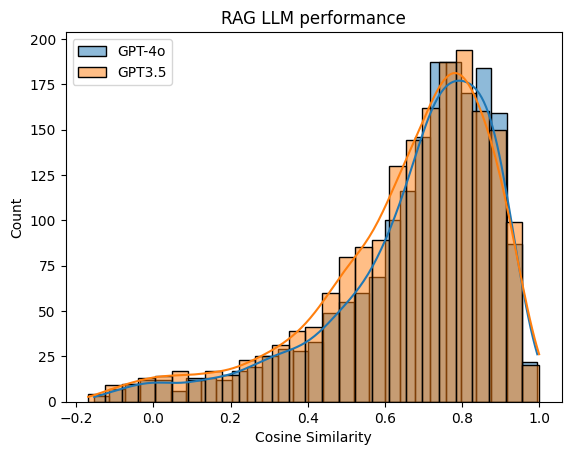

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.histplot(df_gpt4o['cosine'], label='GPT-4o', kde=True)
sns.histplot(df_gpt35['cosine'], label='GPT3.5', kde=True)

plt.title("RAG LLM performance")
plt.xlabel("Cosine Similarity")
plt.legend()

plt.show()

### Cosine Similatiry (GPT-4o-mini)

In [90]:
df_gpt4o_mini = pd.read_csv('data/results-gpt4o-mini.csv')

In [91]:
df_gpt4o_mini.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


## LLM-as-a-Judge

In [88]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [92]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [93]:
samples = df_sample.to_dict(orient='records')

In [94]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp'}

### Compare Using Original Answer

In [95]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [96]:
answer = llm(prompt, model='gpt-4o-mini')

In [97]:
import json

In [98]:
evaluations = []
count = 0

for record in tqdm(samples):
    count += 1

    if count == 10:
        break 
    
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  6%|▌         | 9/150 [00:17<04:36,  1.96s/it]


In [101]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [102]:
df_evaluations = pd.DataFrame(json_evaluations)


In [103]:
df_evaluations.Relevance.value_counts()


Relevance
RELEVANT        8
NON_RELEVANT    1
Name: count, dtype: int64

In [104]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a potential pip...


In [106]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

### Compare Without Original Answer

In [107]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: Where can I find the script for generating the Kitchenware Classification Competition dataset?
Generated Answer: You can find the script for generating the Kitchenware Classification Competition dataset at the following link: kitchenware-dataset-generator | Kaggle.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [108]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by providing a specific location (a link to Kaggle) where the script for generating the Kitchenware Classification Competition dataset can be found, making it highly relevant."
}


In [109]:
evaluations_2 = []
count = 0

for record in tqdm(samples):
    count += 1

    if count == 10:
        break

    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

  6%|▌         | 9/150 [00:15<04:04,  1.73s/it]


In [110]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [112]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [114]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           8
PARTLY_RELEVANT    1
Name: count, dtype: int64

In [120]:
df_evaluations_2[df_evaluations_2.Relevance == 'PARTLY_RELEVANT']['Explanation'].values


array(['The generated answer discusses a potential cause of a pip version error related to Scikit-Learn version conflicts, which could be one of many reasons for a pip version error. However, it does not address other possible causes of pip version errors, such as dependency conflicts or environment issues, and focuses solely on Scikit-Learn. Thus, while it provides relevant information, it does not comprehensively cover the potential causes of the pip version error.'],
      dtype=object)

In [116]:
samples[4]


{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw